**AST4310, Autumn 2020, Julia version**

# Project 5: LTE Line Formation
This project was originally written by Robert J. Rutten, and converted to notebook by Tiago M. D. Pereira.

#### Header and imports

The cells below contain some code to label equations in Markdown and some recommended Julia imports to solve the exercises.

In [1]:
macro javascript_str(s) display("text/javascript", s); end

javascript"""
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});"""

In [2]:
using Unitful
using UnitfulRecipes   # To make unitful play with plots, otherwise need to ustrip(temp)
using Plots
import PhysicalConstants.CODATA2018: c_0, k_B, m_e, h, R_∞
import NumericalIntegration: integrate, cumul_integrate, TrapezoidalFast
import Polynomials: Polynomial
import DelimitedFiles: readdlm
using SpecialFunctions: erfcx

# Units and definitions
i_units = u"kW / m^2 / sr / nm"
@derived_dimension NumberDensity Unitful.𝐋^-3
@derived_dimension PerLength Unitful.𝐋^-1

## 1. Background

<img src="https://tiagopereira.space/ast4310/images/unsold.svg">

*Albrecht O.J. Uns&ouml;ld (1905-1995) was the first, in 1941 at Kiel, to study stellar composition ("abundance analysis")  in the detail permitted by proper physical understanding of line formation (for the B0 dwarf $\tau$ Scorpii, using spectrograms taken during a six-month visit to the US just before the second world war).  He used the so-called "coarse" analysis based on Minnaert's curve of growth for a Schuster-Schwarzschild single "reversing layer" as in the exercise 2 of Project 2.  Later, he led a school of astrophysicists at Kiel in "fine analysis", combining LTE line formation with non-grey stratified atmosphere modeling just as you do in this exercise.  The technique was developed by L.H. Aller, C. de Jager and others in the fifties, and has dominated stellar abundance analysis throughout the second half of the twentieth century. He spelled out its physical basis in great detail in his ["Physik der Sternatmosph&auml;ren"](http://adsabs.harvard.edu/abs/1955psmb.book.....U). Portrait copied from [Hearnshaw (1986)](http://adsabs.harvard.edu/abs/1986asoh.book.....H).*

### 1.1 Solving the Radiative Transfer Equation

#### 1.1.1 Optical Depth

In project 4 you learned about a model atmosphere (FALC model) and continuous extinction. Here we will continue on this topic, using again the FALC model. Once we have the continuous extinction coefficient as function of height, we may compute the corresponding optical depth scale given by:

\begin{equation}
  \tau_\lambda(h_0) 
  \equiv -\int_\infty^{h_0} \alpha_\lambda^c \rm{d} h
              \label{eq:tau_cont}
\end{equation}

at any height $h_0$.  Note that the FALC model is tabulated in reverse order,
corresponding to the $-h$ direction (ie, depth). For the numerical $\tau$ integration, the recommended approach is trapezoidal integration. In this particular case, we want a value of $\tau$ for each height point, so for every point we integrate $\alpha_\lambda$ *up to that point*, and not across the whole range of heights. This is called a *cumulative* integration. Fortunately, `scipy.integrate` has a function `cumtrapz` that does this, so it is possible to calculate $\tau$ with a single call.

#### 1.1.2 Emergent intensity and height of formation

We are now ready to compute the intensity of the radiation 
that emerges from the centre of the solar disk 
(in the radial direction from the solar sphere).
It is given (assuming plane-parallel stratification) by:

\begin{equation}
    \label{eq:formal}
  I_\lambda = \int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda.
\end{equation}

The integrand tells us how much radiation is coming from a given layer, also called the contribution function to intensity:

\begin{equation}
  \frac{\rm{d} I_\lambda}{\rm{d} h} =  
      S_\lambda e^{-\tau_\lambda} \alpha_\lambda
\end{equation}

which shows the contribution of each layer to the emergent intensity.
Its weighted mean defines the "mean height of formation":

\begin{equation}
  <\!h\!> \, \equiv \,
       \frac{\int_0^\infty h \, (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
                      {\int_0^\infty (\rm{d} I_\lambda/\rm{d} h) \rm{d} h}
     = \frac{\int_0^\infty h \, S_\lambda e^{-\tau_\lambda}
                \rm{d} \tau_\lambda}
            {\int_0^\infty S_\lambda e^{-\tau_\lambda}
              \rm{d} \tau_\lambda}.
  \label{eq:meanh}
\end{equation}


#### 1.1.3 Intensity from different directions and flux integration

The solar disk-centre intensity can be calculated by using the integral expression for $S_\lambda \mathrm{e}^{-\tau_\lambda}$, which you can integrate with `numpy.trapz`. For the general case with different inclinations (given by $\mu=\cos\theta$) in a 1D plane-parallel atmosphere, the emergent intensity is given by

\begin{equation}
    I_\lambda(0, \mu) = \int_0^\infty S_\lambda \mathrm{e}^{-\tau_\lambda/\mu}d\tau_\lambda/\mu.
    \label{eq:ilambda}
\end{equation}

We transform $\tau_\lambda \to \tau_\lambda/\mu$, meaning that inclined rays go through more material to reach the same depth in the z axis, and this increase in path length also increases the optical depth. This expression can be used to compute the intensity for any inclination (in the 1D case), we can use it to calculate the flux $\cal{F}_\lambda$:

\begin{equation}
    \mathcal{F}_\lambda = \int I_\lambda \mathrm{d}\Omega  = 2\pi\int_{-1}^1\mu I_\lambda \mathrm{d}\mu
\end{equation}

Note that in the lecture notes the flux $\mathcal{F}_\lambda = \pi F_\lambda$, is called "flux", while $F_\lambda$ is called the "astrophysical flux". They differ only by a factor of $\pi$ for a spherical radiator. In this assignment we will only use the astrophysical flux (when we refer, for simplicity, as "flux"). For a spherical emitter, and getting only the emergent (outgoing) flux, we have:

\begin{equation}
    F^+_\lambda = 2\int_0^1\mu I_\lambda(0, \mu)\, \mathrm{d}\mu
\end{equation}

Equation (\ref{eq:ilambda}) can be used evaluate $I_\lambda(0, \mu)$, but it cannot be evaluated at $\mu$=0. The naive way to get $F$ is simply to integrate $I_\lambda(0,\mu)$ trapezoidally over a range of angles, e.g. $\mu$ = 0.1, 0.2, ..., 1.0, but that
produces too much flux, even while ignoring the small contribution from the outer limb ($\mu$ = 0.0-0.1, $\sin\theta$ = 0.995-1), because $I_\lambda(0,\mu) \, \mu$ is a concave function ill-fitted with straight segments. This integral is therefore better evaluated with "open quadrature", an integration formula neglecting the endpoints. Classical equal-spacing recipes are the Open Newton-Cotes quadrature formulae but it is much better to use non-equidistant [Gaussian quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature), that approximate:

\begin{equation*}
    \int_{-1}^1 f(x)\, \mathrm{d}x \approx \sum_{i=1}^{n}w_i f(x_i).
\end{equation*}

In our case, $n$ is the number of rays (or directions) that we will compute $I_\lambda(0,\mu)$ for. The points $x_i$ and the weights $w_i$ are defined in the Gaussian quadrature. The last thing to note is that $x_i$ and $w_i$ are defined for an integral from $-$1 to 1, but we want from 0 to 1. So we must modify them accordingly:

\begin{eqnarray*}
    x'_i  & = &  \frac{x_i}{2} +\frac{1}{2}\\
    w'_i & = & \frac{w_i}{2} 
\end{eqnarray*}

To calculate the astrophysical flux, a Gaussian quadrature with three rays ($n$=3) is a reasonable choice. You can use the following values:

In [3]:
# Three-point Gaussian integration intensity -> flux
# rescale mu range from [-1, 1] to [0, 1]
μ_gauss = [-sqrt(3/5) 0.0 sqrt(3/5)] ./ 2 .+ 0.5 
weight_gauss = [5/9 8/9 5/9] / 2;

### 1.2 The Na I D lines

The Na I D lines are a pair of strong spectral lines, among the strongest in the solar spectrum. They were named D$_1$ and D$_2$ by [Joseph von Fraunhofer](https://en.wikipedia.org/wiki/Fraunhofer_lines), with the letter D coming from his original classification. In this exercise we will compute the Na I D line profiles using the FALC and the 3D model atmospheres, and also compare with observations.

The file `int_nad.dat` contains spectra of the lines (and the surrounding region) taken from the atlas of [Wallace et al. (1998)](https://ui.adsabs.harvard.edu/abs/1998assp.book.....W), observed with the Fourier Transform Spectrometer (FTS) at the [McMath-Pierce solar telescope](https://en.wikipedia.org/wiki/McMath%E2%80%93Pierce_solar_telescope) (still the largest solar telescope in the world, although mostly retired now) at [Kitt Peak](https://en.wikipedia.org/wiki/Kitt_Peak_National_Observatory). The [FTS](https://www.noao.edu/noao/staff/plymate/fts/aboutFTS.html) remains the highest spectral resolution spectrograph in astrophysics (resolving power $R > $ 10$^6$). The spectra in the file are for disk-centre ($\mu =$ 1) intensity, and are normalised by the continuum intensity. 

The file contains wavenumbers (first column), intensities (third column), and other quantities we don't need. We can load it, convert wavenumbers to wavelengths and assign units by doing the following:

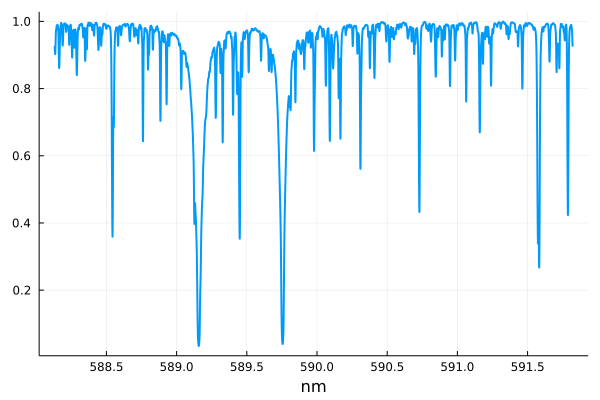

In [4]:
tmp = readdlm("int_nad.dat")
wnum = tmp[:, 1] * u"cm^-1"
wave = (1 ./ wnum) .|> u"nm"
sp_obs = tmp[:, 3]

plot(wave, sp_obs, w=2, label=false)

The Na I D$_1$ and D$_2$ are the two strongest lines. The line properties are listed in the table below.


|                  | Na I D$_1$ | Na I D$_2$ |
|------------------|-----------:|-----------:|
| Air wavelength (nm)  | 589.755         | 589.158  |
| Lower level      |  3s\,2S$_{1/2}$ | 3s\,2S$_{1/2}$ |
| Upper level      |  3p\,2P$^{\rm o}_{1/2}$ | 3p\,2P$^{\rm o}_{3/2}$ |
| $\chi_{1,l}$ (aJ)| 0     | 0      |
| $\chi_{1,u}$ (aJ)| 0.3368| 0.3371 |
|   $g_l$          | 2     | 2      |
|   $g_u$          | 2     | 4      |
| $f_{lu}$         | 0.318 | 0.631  |

They are resonance lines of sodium and therefore share the lower level. The Na ionisation energy of first ionisation ($\chi_\infty$) is 0.823 aJ, and subsequent ionisation energies are much higher (7.58 aJ and 11.48 aJ).

### 1.3 LTE Line Formation

We now have almost all the necessary ingredients to calculate the Na I D$_1$ line for the FALC model atmosphere. As a plane-parallel atmosphere, we saw earlier that the emergent intensity can be calculated from the formal solution to the radiative transfer equation, equation (2).

The two unknowns in the integrand are the source function and the optical depth. 

We will assume LTE for the line source function. Since LTE holds already for the continuum processes at these
wavelengths (being dominated by H$^-$ bound-free transitions),
the assumption of LTE line formation implies that you can simply set
$S_\lambda^l = S_\lambda^c = S_\lambda^\mathrm{total} = B_\lambda(T)$. What remains is first to evaluate the line extinction as a function of
height and wavelength, and then to add that to the continuous extinction
calculated in the Project 4. We need to calculate the intensity for the wavelengths of the Na I D$_1$ profile.

The monochromatic line extinction per m path length for a bound-bound transition between a lower level $l$  and an upper level $u$ is given by (in SI units):
\begin{equation}
\tag{8}
\label{eq:alpha}
\alpha_\lambda^l = \frac{e^2}{4\varepsilon_0 m_ec}\frac{\lambda^2}{c}\frac{n_l^\mathrm{LTE}}{N_E}N_H A_E f_{lu}\frac{H(a, v)}{\sqrt{\pi}\Delta\lambda_D}\left[1 - \mathrm{e}^{-hc/\lambda k_B T}\right]
\end{equation}

This is a slightly modified version of $\alpha_\nu$ from the lecture notes (Section 5.4, page 62): the differences are that we explicitly write the broadening profile as the Voigt profile $V(a, \lambda)\equiv H(a, v)/(\sqrt{\pi}\Delta\lambda_D)$, a factor of $\lambda^2 / c$ from converting the frequency profile to wavelength profile, and writing the lower-level populations $n_l$ as a relative element population, hydrogen density, and element abundance ($A_E$).

We will now discuss how to calculate all the components of equation (\ref{eq:alpha}). Many of the terms are fundamental constants or are given in table above. For the element abundance $A_E$ for sodium use the value from [Asplund et al. (2009)](http://adsabs.harvard.edu/abs/2009ARA%26A..47..481A): $A_{Na}$ = 1.7378 $\cdot$ 10$^{-6}$. Two main terms remain: the level populations and the line profile.

#### 1.3.1 Level populations

The LTE population fraction $n_l^\mathrm{LTE}/N_\mathrm{E}$ (lower level
population scaled by the total element population) is given by the
combined Saha and Boltzmann distributions

\begin{eqnarray*}
   U_r 
   &\equiv& \sum_s g_{r,s} e^{-\chi_{r,s}/kT}
             \label{eq:parfunc} \\
   \frac{n_{r,s}}{N_r}
   &=& \frac{g_{r,s}}{U_r} e^{-\chi_{r,s}/kT}
             \label{eq:Boltzmann} \\
   \frac{N_{r+1}}{N_r}
   &=& \frac{1}{N_\mathrm{e}} \frac{2U_{r+1}}{U_r}
       \left(\frac{2 \pi m_\mathrm{e} kT}{h^2}\right)^{3/2} 
       e^{-\chi_r/kT},
            \label{eq:Saha}
\end{eqnarray*}

where $s$ is the level counter and $r$ the ionisation stage
counter. The level populations can be calculated in the same way as you've done for Project 1. In the current directory you can find a model atom of Na I (plus a single state of Na II), called `NaI_atom.txt`. Have a look at the model atom file. It is very simple and has only the Na I D lines, plus the first state of Na II to calculate the partition function. The reason for this simplicity is to save on needless calculations, since you don't need information about the other levels to compute the Na I D lines.

#### 1.3.2 Line Profile and Broadening

The Voigt function  $H(a,v)$ describes the extinction profile shape and is defined by:

\begin{eqnarray*}
   H(a,v) &\equiv& \frac{a}{\pi} \int_{-\infty}^{+\infty}
            \frac{e^{-y^2}}{(v - y)^2 + a^2} \mathrm{d} y
                          \label{eq:Voigt} \\[1ex]
   y &=& \frac{v_\mathrm{los}}{c} \frac{\lambda_0}{\Delta \lambda_\mathrm{D}}\\
   v &=& \frac{\lambda-\lambda_0}{\Delta \lambda_\mathrm{D}}   
                          \label{eq:Voigtv} \\
   a &=& \frac{\lambda^2}{4\pi c}\frac{\gamma}{\Delta \lambda_\mathrm{D}},
                          \label{eq:Voigta} 
\end{eqnarray*}

where $v_\mathrm{los}$ is the velocity along the line of sight and $a$ the damping parameter. The Doppler width $\Delta \lambda_\mathrm{D}$ is not only set by the thermal broadening but in the 1D case it includes also the microturbulent "fudge parameter"  $v_\mathrm{turb}$ through defining it as:

\begin{equation*}
   \Delta \lambda_\mathrm{D} 
      \equiv \frac{\lambda_0}{c} \sqrt{\frac{2kT}{m} + v_\mathrm{turb}^2}
    \label{eq:microturbulence}
\end{equation*}
where $m$ is the mass of the line-causing particle in kilograms,
for sodium $m_\mathrm{Na} = 22.99 \times 1.6605 \times 10^{-27}$ kg.

The damping parameter $a$ may be approximated by taking only Van der Waals broadening into account. Figure 11.6 of [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G) shows this by comparing Van der Waals broadening with natural broadening and Stark broadening for the Na I D lines throughout a solar radiative-equilibrium model. However, since the model atmospheres reach higher we might also add in natural broadening width:

\begin{equation*}
   \gamma_\mathrm{rad} = A_{ul} = 
   6.67 \times 10^{13} \frac{g_l}{g_u} \, \frac{f_{lu}}{\lambda^2}
            \;\;\;\left[\mathrm{s}^{-1}\right],
      \label{eq:gamrad}
\end{equation*}
for $\lambda$ in nm.

The classical evaluation recipe of Van der Waals broadening by [Uns&ouml;ld (1955)](http://adsabs.harvard.edu/abs/1955psmb.book.....U)
is (cf. [Warner (1967)](http://adsabs.harvard.edu/abs/1967MNRAS.136..381W)):

\begin{equation*}
     \log \gamma_\mathrm{vdW} \approx 6.33
                     + 0.4 \log \left(\overline{r_u^2}-\overline{r_l^2}\right)
                     + \log P_g - 0.7 \log T   \;\;\;\left[\log\left(\mathrm{s}^{-1}\right)\right],
    \label{eq:vanderWaals}
\end{equation*}
 
where $P_g$ is given in cgs units (Ba), $T$ is given in K, and the mean square radii $\overline{r^2}$
of the upper and lower level are usually estimated from the 
hydrogenic approximation of [Bates and Damgaard (1949)](http://adsabs.harvard.edu/abs/1948ApJ...107..383B):

\begin{equation*}
    \overline{r^2} = \frac{{n^\ast}^2}{2 Z^2}
            \left( 5 {n^\ast}^2 +1 - 3l(l+1)\right)
    \label{eq:Bates-Damgaard}
\end{equation*}

with $\overline{r^2}$ measured in atomic units,
$l$ the angular quantum number of the level and
$n^\ast$ its effective (hydrogen-like) principal quantum number 
given by

\begin{equation*}
   {n^\ast}^2 = R \frac{Z^2}{\chi_\infty - \chi_n}
    \label{eq:effectiven}
\end{equation*}

in which the Rydberg constant $R$ = 2.18 aJ, $Z$ is the ionisation stage ($Z$ = 1 for Na I, $Z$ = 2 for Na II, etc)
and $\chi_\infty - \chi_n$ is the ionisation energy from the level $n$ (either the upper level or lower level, see above for values of $\chi_\infty$, $\chi_{1,l}$, and $\chi_{1,u}$).
The common Na I D$_1$ and Na I D$_2$ lower level (3s\,2S$_{1/2}$) has $l=0$, the upper levels (3p\,$^2$P$_{1/2}$ and  3p\,$^2$P$_{3/2}$) have $l=1$. 

Because $\gamma_\mathrm{rad}$ and $\gamma_\mathrm{vdW}$ are both associated with a Lorentzian profile, we can just sum them into $\gamma$ and replace that in the equation for the damping $a$:

\begin{equation*}
   \gamma = \gamma_\mathrm{rad} + \gamma_\mathrm{vdW}
\end{equation*}

You can use the same `voigt` function you used in Project 2; it computes the profile $H(a,v)$.



---


### Exercise 1: Continuum Optical Depth and Height of Formation

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Similar to what you've done in Project 4, compute the H$^-$ extinction as a function of height for the FALC model at at $\lambda$ = 0.5 μm. Now use it to compute the optical depth as function of height, $\tau_{500}$. Plot this against the $\tau_{500}$ from the FALC model (saved in `falc['tau_500']`). There should be a mismatch, discuss it. (Hint: recompute $\tau_{500}$ by adding also extinction from Thomson scattering.)

* Using the continuous extinction you computed above (from H$^-$ and Thomson scattering), use equation (4) to compute $<\!h\!>$, the  mean height of formation at 500 nm. What is the meaning of this value?
    
* Compute and plot the contribution function from equation (3) for 500 nm and compare with $<\!h\!>$ (plot it as a vertical line in the same figure). Discuss the shape of the curve and its meaning.
    
* Repeat the above normalised contribution plot for $\lambda$ = 1 μm, $\lambda$ = 1.6 μm, and $\lambda$ = 5 μm (all in same plot). Discuss the changes of the contribution functions and their cause.

* Compare the continuum intensity observations from Project 4 (exercise 2) with the predicted continuum intensities from the FALC model. Compute the total optical depth (H$^-$ and Thomson scattering) as in Project 4 (exercise 3), for the FALC model and for the same wavelengths in the observations. Assume LTE, so $S_\lambda \equiv B_\lambda$, and integrate equation (2) to get the emergent intensity. Convert your calculations and the observations to the units of  kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$ and plot them together. Discuss any differences between the two plots - what could be the underlying physical reasons?
</div>

### Exercise 2: The Na I partition function

The partition function $U_r$ is important to correctly compute a spectral line profile. An accurate value relies on having the atomic level energies for several excited states, but in our simple atom `NaI_atom.txt` we have only two excited states in neutral sodium. Is it good enough? [Gray (1992)](http://adsabs.harvard.edu/abs/1992oasp.book.....G) gives the following recipe for the Na I partition function: 

$$
\log U_\mathrm{Na\,I}(T) \approx c_0 + c_1 \log \theta + c_2 \log^2 \theta + c_3 \log^3 \theta + c_4 \log^4 \theta,
$$

with $\theta \equiv 5040./T$ (with $T$ in K) and $c_0 = 0.30955$, $c_1=-0.17778$, $c_2=1.10594$, $c_3=-2.42847$ and $c_4=1.70721$. In the 2005 version of the book, these fits were replaced by a table, which you can use if you prefer.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">

* Check how far we are from a better partition function by comparing the approach followed in Project 1 with the `NaI_atom.txt` file with Gray's recipe at 5000 K and 6000 K.     
</div>

### Exercise 3: Computing the Na I D line profile

You now have all the ingredients to compute the Na I D$_1$ line profile from a model solar atmosphere, the FALC model. Such calculation, also known as the predicted spectrum or synthetic spectrum, will give the line profile you would expect to observe if the FALC was a real star. It can then be used to compare with actual observations, where a good match would suggest the model reproduces the mean atmospheric stratification of the star. An accurate calculation of a line profile thus depends critically on knowning many details: from a good model of the star's atmosphere, accurate knowledge about atomic physics and properties of the transition, and detailed radiative transfer calculations. In this exercise, you will see if all of those ingredients are up to the task: compute the Na I D$_1$ line profile and compare with observations.

<div style="background-color:#e6ffe6; padding:10px; border-style:
solid;; border-color:#00e600; border-width:1px">
    
* Code all the ingredients above together with the continuum exctinction from exercise 1 into appropriate functions for each quantity (line extinction, continuum extinction, profile, level populations, integration). 
    
* Use equation (2) to compute the disk-centre ($\mu$ = 1) intensity for the Na I D$_1$ line for the FALC model. Calculate the profile for about 200 wavelength points, centred at the line core, and extending 0.1 nm on either side. Plot the normalised line profile against the observations from `int_nad.dat` and discuss the differences. Explain why your computed profile has a line-centre reversal.
    
* Use equation (5) to compute $\mu$=0.2 intensity for the Na I D$_1$ line for the FALC model. Plot the line profiles for $\mu$=1 and 0.2 in an absolute scale and discuss the differences.
    
* Use equation (5) to compute the limb darkening $I_\lambda(0, \mu)/I_\lambda(0, \mu=1)$ for two wavelengths in the Na I D$_1$ line: in the far blue wing, and in the line core. Calculate $I_\lambda(0, \mu)$ for several equally-spaced values of $\mu$, e.g. $\mu=0.1, 0.2, ..., 1.0$. Plot the limb darkening (also known as centre-to-limb variation) as a function of $\mu$ and separately as a function of radius of the apparent solar disk, $r/R_\odot= \sin\theta$. Explain the limb darkening and its variation with wavelength.
    
* Use the flux integration described above to compute the astrophysical flux $F^+_\lambda$ for the Na I D$_1$ line for the FALC model. Plot the normalised flux against the normalised disk-centre intensity and discuss any differences. Why are they not the same?
    
</div>    